In [15]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split


## Only 4 classes

In [16]:
import os
from collections import defaultdict

base_path = "DiffusionEmotion_S/cropped"

emotion_map = {
    "sad": "Nervous",
    "fear": "Nervous",
    "happy": "Confident",
    "neutral": "Neutral",
    "angry": "Defensive",
    "disgust": "Defensive",
    "contempt": "Defensive",
    "surprise": "Neutral"
}

mapped_counts = defaultdict(int)

for raw_label in os.listdir(base_path):
    folder_path = os.path.join(base_path, raw_label)

    if not os.path.isdir(folder_path):
        continue

    # Count images in this raw emotion folder
    n_images = len([
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])

    # Apply mapping
    mapped_label = emotion_map.get(raw_label.lower(), "Unknown")

    # Add to new class counter
    mapped_counts[mapped_label] += n_images

    print(f"{raw_label:10s} → {mapped_label:10s} : {n_images} images")

print("\nTOTAL IMAGES PER NEW CLASS")
for mapped_label, total in mapped_counts.items():
    print(f"{mapped_label:10s}: {total}")


angry      → Defensive  : 178 images
disgust    → Defensive  : 88 images
fear       → Nervous    : 72 images
happy      → Confident  : 340 images
neutral    → Neutral    : 348 images
sad        → Nervous    : 81 images
surprise   → Neutral    : 182 images

TOTAL IMAGES PER NEW CLASS
Defensive : 266
Nervous   : 153
Confident : 340
Neutral   : 530


In [17]:
import os
from sklearn.model_selection import train_test_split
from collections import defaultdict

new_classes = ["Confident", "Nervous", "Neutral", "Defensive"]
class_to_idx = {cls: i for i, cls in enumerate(new_classes)}

all_image_paths = []
all_labels = []

# Load all images and assign mapped labels
for raw_label in os.listdir(base_path):
    folder_path = os.path.join(base_path, raw_label)

    if not os.path.isdir(folder_path):
        continue

    mapped = emotion_map.get(raw_label.lower(), None)
    if mapped is None:
        continue  

    mapped_idx = class_to_idx[mapped]

    image_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    # add each image to dataset
    for f in image_files:
        all_image_paths.append(os.path.join(folder_path, f))
        all_labels.append(mapped_idx)

# 70% train, 30% temp
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels,
    test_size=0.30,
    stratify=all_labels,
    random_state=42
)

# split temp (15% val, 15% test)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    random_state=42
)

total = len(all_labels)
print(f"\nTrain: {len(train_paths)} images ({len(train_paths)/total*100:.1f}%)")
print(f"Val:   {len(val_paths)} images ({len(val_paths)/total*100:.1f}%)")
print(f"Test:  {len(test_paths)} images ({len(test_paths)/total*100:.1f}%)")

print("\nCLASS DISTRIBUTIONS")

def print_dist(name, labels):
    print(f"\n{name}:")
    for i, cls in enumerate(new_classes):
        count = labels.count(i)
        pct = count / len(labels) * 100
        print(f"  {cls:10s}: {count} ({pct:.1f}%)")

print_dist("Train", train_labels)
print_dist("Val", val_labels)
print_dist("Test", test_labels)


Train: 902 images (70.0%)
Val:   193 images (15.0%)
Test:  194 images (15.1%)

CLASS DISTRIBUTIONS

Train:
  Confident : 238 (26.4%)
  Nervous   : 107 (11.9%)
  Neutral   : 371 (41.1%)
  Defensive : 186 (20.6%)

Val:
  Confident : 51 (26.4%)
  Nervous   : 23 (11.9%)
  Neutral   : 79 (40.9%)
  Defensive : 40 (20.7%)

Test:
  Confident : 51 (26.3%)
  Nervous   : 23 (11.9%)
  Neutral   : 80 (41.2%)
  Defensive : 40 (20.6%)


## Classes + valence + arousal

In [20]:
emotion_map = {
    "sad": "Nervous",
    "fear": "Nervous",
    "happy": "Confident",
    "neutral": "Neutral",
    "angry": "Defensive",
    "disgust": "Defensive",
    "contempt": "Defensive",
    "surprise": "Neutral"
}

new_classes = ["Confident", "Nervous", "Neutral", "Defensive"]

csv_path = "DiffusionEmotion_S/dataset_sheet.csv"
df = pd.read_csv(csv_path)

df["raw_emotion"] = df["subDirectory_filePath"].apply(lambda p: p.split("/")[1])
df["filename"] = df["subDirectory_filePath"].apply(lambda p: p.split("/")[2])

base_real_path = "DiffusionEmotion_S/cropped"

df["real_path"] = df.apply(
    lambda row: os.path.join(base_real_path, row["raw_emotion"], row["filename"]),
    axis=1
)

df = df[df["real_path"].apply(os.path.exists)].reset_index(drop=True)

df["valence"] = df["valence"].astype(float)
df["arousal"] = df["arousal"].astype(float)

df["mapped_emotion"] = df["raw_emotion"].map(emotion_map)

In [21]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["mapped_emotion"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["mapped_emotion"],
    random_state=42
)

def print_stats(name, split_df):
    print(f"\n===== {name.upper()} SET =====")

    # Class distribution
    total = len(split_df)
    print("\nClass distribution:")
    for cls in new_classes:
        c = (split_df["mapped_emotion"] == cls).sum()
        print(f"{cls:10s}: {c} ({c/total*100:.1f}%)")

    # Overall valence/arousal
    print("\nValence stats:")
    print(split_df["valence"].describe())

    print("\nArousal stats:")
    print(split_df["arousal"].describe())

    print("\n--- PER CLASS STATS ---")
    for cls in new_classes:
        subset = split_df[split_df["mapped_emotion"] == cls]
        print(f"\n{cls} (n={len(subset)})")
        print("Valence:")
        print(subset["valence"].describe())
        print("Arousal:")
        print(subset["arousal"].describe())



In [22]:
print_stats("train", train_df)
print_stats("val", val_df)
print_stats("test", test_df)


===== TRAIN SET =====

Class distribution:
Confident : 238 (26.4%)
Nervous   : 107 (11.9%)
Neutral   : 371 (41.1%)
Defensive : 186 (20.6%)

Valence stats:
count    902.000000
mean      -0.038248
std        0.344660
min       -1.000000
25%       -0.300000
50%        0.000000
75%        0.300000
max        0.700000
Name: valence, dtype: float64

Arousal stats:
count    902.000000
mean       0.225166
std        0.257234
min       -0.300000
25%        0.000000
50%        0.200000
75%        0.400000
max        1.000000
Name: arousal, dtype: float64

--- PER CLASS STATS ---

Confident (n=238)
Valence:
count    238.000000
mean       0.407983
std        0.098829
min        0.000000
25%        0.400000
50%        0.400000
75%        0.500000
max        0.700000
Name: valence, dtype: float64
Arousal:
count    238.000000
mean       0.273529
std        0.147886
min        0.000000
25%        0.100000
50%        0.300000
75%        0.400000
max        0.700000
Name: arousal, dtype: float64

Nervo

Results show:

The overall valence/arousal distributions remain stable across train, val, and test.

Each mapped class exhibits consistent affective profiles:

Confident: positive valence, moderate arousal

Nervous: negative valence, low arousal

Neutral: near-zero valence, low-to-medium arousal

Defensive: strongly negative valence, high arousal

Valence and arousal provide a continuous representation of emotion that complements the discrete class labels. While the mapped classes (Confident, Nervous, Neutral, Defensive) describe what emotion is present, the valence–arousal dimensions describe how strongly and in what direction that emotion is expressed.

Using device: cuda
Raw label counts:
Train: [238 107 371 186]
Val:   [51 23 79 40]
Test:  [51 23 80 40]

After image verification:
Train: 902, Val: 193, Test: 194

Extracting DINO features for Train/Val/Test ...
DINO features extracted for 100/902 images
DINO features extracted for 200/902 images
DINO features extracted for 300/902 images
DINO features extracted for 400/902 images
DINO features extracted for 500/902 images
DINO features extracted for 600/902 images
DINO features extracted for 700/902 images
DINO features extracted for 800/902 images
DINO features extracted for 900/902 images
DINO features extracted for 100/193 images
DINO features extracted for 100/194 images
DINO feature shapes: (902, 384) (193, 384) (194, 384)

===== Start SVM Grid Search (DINO + SVM) =====
Fitting 10 folds for each of 84 candidates, totalling 840 fits

Best params: {'svm__C': 5, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale'}
Best CV macro-F1: 0.8266287711217652

===== Best Model (DINO + SVM

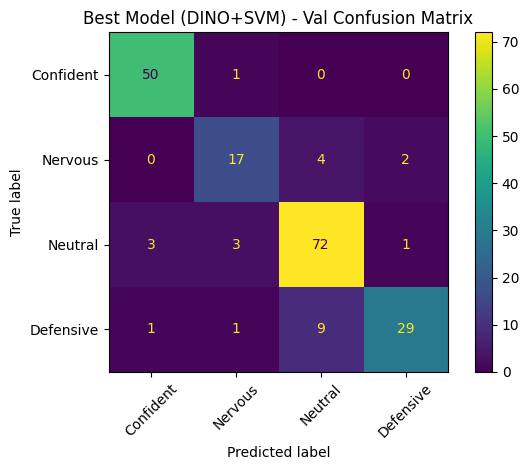


===== Best Model (DINO + SVM) - Test Report =====
              precision    recall  f1-score   support

   Confident       1.00      0.94      0.97        51
     Nervous       0.71      0.65      0.68        23
     Neutral       0.85      0.95      0.90        80
   Defensive       0.92      0.82      0.87        40

    accuracy                           0.89       194
   macro avg       0.87      0.84      0.85       194
weighted avg       0.89      0.89      0.89       194



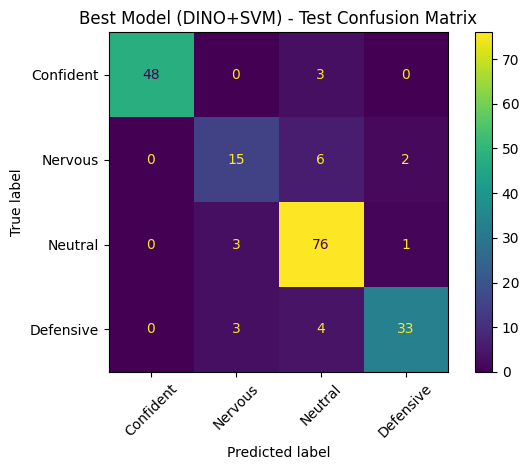


================ Summary =================
Best Model (DINO+SVM, RBF) - Val acc: 0.8705, Test acc: 0.8866, Test F1: 0.8548, Test Recall: 0.8421, Train+CV time: 117.080s


In [24]:

import numpy as np
import torch
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from transformers import AutoImageProcessor, AutoModel


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class_to_idx = {cls: i for i, cls in enumerate(new_classes)}
num_classes = len(new_classes)


def df_to_xy(split_df):

    X = split_df["real_path"].to_numpy()
    y = split_df["mapped_emotion"].map(class_to_idx).to_numpy().astype(int)
    return X, y

X_train, y_train = df_to_xy(train_df)
X_val,   y_val   = df_to_xy(val_df)
X_test,  y_test  = df_to_xy(test_df)

print("Raw label counts:")
print("Train:", np.bincount(y_train, minlength=num_classes))
print("Val:  ", np.bincount(y_val,   minlength=num_classes))
print("Test: ", np.bincount(y_test,  minlength=num_classes))


def filter_valid_images(paths, labels):
    valid_paths, valid_labels = [], []
    for p, lab in zip(paths, labels):
        try:
            with Image.open(p) as img:
                img.verify()
            valid_paths.append(p)
            valid_labels.append(lab)
        except (UnidentifiedImageError, OSError):
            continue
    return np.array(valid_paths), np.array(valid_labels)

X_train, y_train = filter_valid_images(X_train, y_train)
X_val,   y_val   = filter_valid_images(X_val,   y_val)
X_test,  y_test  = filter_valid_images(X_test,  y_test)

print("\nAfter image verification:")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

if len(X_train) == 0:
    raise RuntimeError("No valid train images found, please check paths.")


def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(cm, display_labels=new_classes)
    disp.plot(xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return cm

#DINO 
pretrained_model_name = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
dino_model = AutoModel.from_pretrained(pretrained_model_name)
dino_model.to(device)
dino_model.eval()

@torch.inference_mode()
def extract_dino_features(paths):
    feats = []
    for idx, p in enumerate(paths):
        img = Image.open(p).convert("RGB")
        inputs = processor(images=img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = dino_model(**inputs)
        pooled = outputs.pooler_output.detach().cpu().numpy()  # [1, D]
        feats.append(pooled[0])
        if (idx + 1) % 100 == 0:
            print(f"DINO features extracted for {idx+1}/{len(paths)} images")
    return np.stack(feats, axis=0)

print("\nExtracting DINO features for Train/Val/Test ...")
X_train_dino = extract_dino_features(X_train)
X_val_dino   = extract_dino_features(X_val)
X_test_dino  = extract_dino_features(X_test)

print("DINO feature shapes:",
      X_train_dino.shape, X_val_dino.shape, X_test_dino.shape)

#SVM 
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

param_grid = {
    "svm__C": [0.1, 1, 3, 5, 7, 9, 10],
    "svm__gamma": ["scale", 1e-3, 3e-3, 1e-2, 3e-2, 1e-1],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\n===== Start SVM Grid Search (DINO + SVM) =====")
start_time_svm = time.time()
grid.fit(X_train_dino, y_train)
train_time_svm = time.time() - start_time_svm

print("\nBest params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

best_svm = grid.best_estimator_


y_val_pred_svm = best_svm.predict(X_val_dino)
acc_val_svm = accuracy_score(y_val, y_val_pred_svm)

y_test_pred_svm = best_svm.predict(X_test_dino)
acc_test_svm = accuracy_score(y_test, y_test_pred_svm)
f1_test_svm = f1_score(y_test, y_test_pred_svm, average="macro")
recall_test_svm = recall_score(y_test, y_test_pred_svm, average="macro")

print("\n===== Best Model (DINO + SVM) - Val Report =====")
print(classification_report(y_val, y_val_pred_svm, target_names=new_classes))
cm_val_svm = plot_cm(y_val, y_val_pred_svm, "Best Model (DINO+SVM) - Val Confusion Matrix")

print("\n===== Best Model (DINO + SVM) - Test Report =====")
print(classification_report(y_test, y_test_pred_svm, target_names=new_classes))
cm_test_svm = plot_cm(y_test, y_test_pred_svm, "Best Model (DINO+SVM) - Test Confusion Matrix")

print("\n================ Summary =================")
print(
    f"Best Model (DINO+SVM, RBF) - "
    f"Val acc: {acc_val_svm:.4f}, "
    f"Test acc: {acc_test_svm:.4f}, "
    f"Test F1: {f1_test_svm:.4f}, "
    f"Test Recall: {recall_test_svm:.4f}, "
    f"Train+CV time: {train_time_svm:.3f}s"
)
